In [37]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

%matplotlib inline
pd.set_option('display.max_columns', None)

In [52]:
# Define a dictionary with the SAM valence, arousal, and dominance values for each Ekman emotion
vad_mapping = {
    "Happy": [1, 1, 1],
    "Sad": [-1, -1, -1],
    "Angry": [-1, 1, 1],
    "Fear": [-1, 1, -1],
    "Disgust": [-1, 0, -1],
    "Surprise": [0, 1, 0],
    "Neutral": [0, 0, 0],
}

emotions = ["Angry", "Disgust", "Happy", "Sad", "Surprise", "Fear", "Neutral"]
vad = ["Valence", "Arousal", "Dominance"]

In [53]:
df = pd.read_csv('/home/moritz/Workspace/masterthesis/data/identities/short_clip_debug.csv')

preprocessing_pipeline = [
    LinearInterpolator(),
    RollingAverageSmoother(
        window_size=150,
        cols=[
            "Angry",
            "Disgust",
            "Happy",
            "Sad",
            "Surprise",
            "Fear",
            "Neutral",
        ],
    ),
]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(df)

In [54]:
# Generate Valence, Arousal, and Dominance columns
for index, row in pre_df.iterrows():
    weighted_sam_values = [0, 0, 0]
    for emotion in vad_mapping:
        # get the value of the emotion for the row
        emotion_value = row[emotion]
        # calculate the weighted VAD value for the emotion
        weighted_sam_value = [x * emotion_value for x in vad_mapping[emotion]]
        # add the weighted SAM value to the total
        weighted_sam_values = [x + y for x, y in zip(weighted_sam_values, weighted_sam_value)]
    # add new columns for the valence, arousal, and dominance values
    pre_df.at[index, 'Valence'] = weighted_sam_values[0]
    pre_df.at[index, 'Arousal'] = weighted_sam_values[1]
    pre_df.at[index, 'Dominance'] = weighted_sam_values[2]
    
pre_df.head()

,Frame,ClassID,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,GazeDetections,Brightness,Valence,Arousal,Dominance
0,0,person_id1,0.887372,892.685791,143.625381,0.063272,0.034150,0.076438,0.125243,0.062755,0.061847,0.576295,[],143.574166,-0.208074,0.139069,-0.081530
1,1,person_id1,0.885853,891.871851,143.931470,0.062455,0.033711,0.075589,0.126996,0.062228,0.062026,0.576996,[],143.570378,-0.209599,0.135301,-0.084689
2,2,person_id1,0.884333,891.057910,144.237558,0.061660,0.033283,0.074769,0.128706,0.061718,0.062199,0.577665,[],143.566591,-0.211078,0.131640,-0.087758
3,3,person_id1,0.882813,890.243970,144.543646,0.060887,0.032866,0.073978,0.130373,0.061225,0.062366,0.578305,[],143.562803,-0.212514,0.128083,-0.090740
4,4,person_id1,0.881294,889.430029,144.849734,0.060134,0.032460,0.073215,0.132000,0.060748,0.062528,0.578915,[],143.559016,-0.213907,0.124624,-0.093639


/tmp/ipykernel_685701/248835882.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


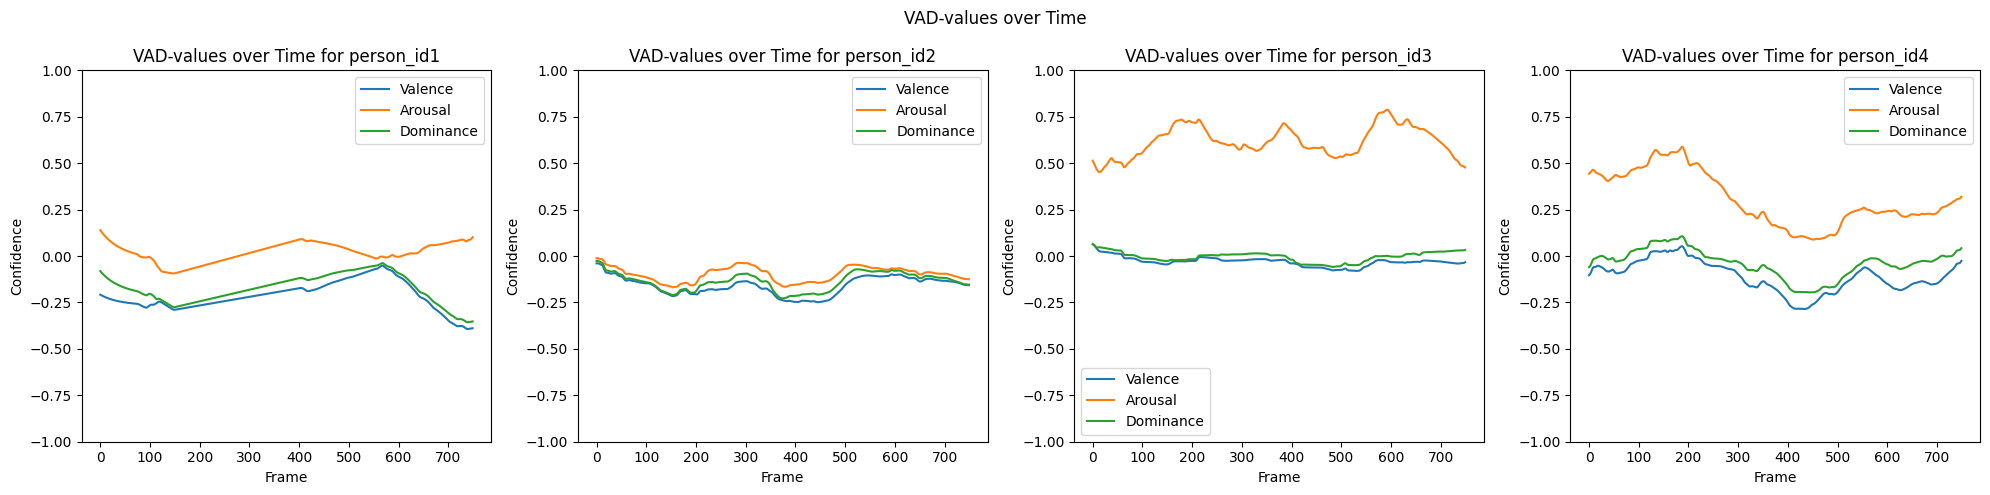

In [58]:
grouped = pre_df.groupby("ClassID")

fig = plt.figure(figsize=(20, 5), tight_layout=True)
fig.suptitle("VAD-values over Time")

for i, (person_id, group) in enumerate(grouped):
    emotions_rolling = group[
        [
            "Frame",
            *vad
        ]
    ]

    ax = fig.add_subplot(1, 4, i + 1)
    emotions_rolling.plot(
        x="Frame",
        y=vad,
        ax=ax,
    )

    ax.set_title(f"VAD-values over Time for {person_id}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("Confidence")
    ax.set_ylim(-1, 1)

fig.show()

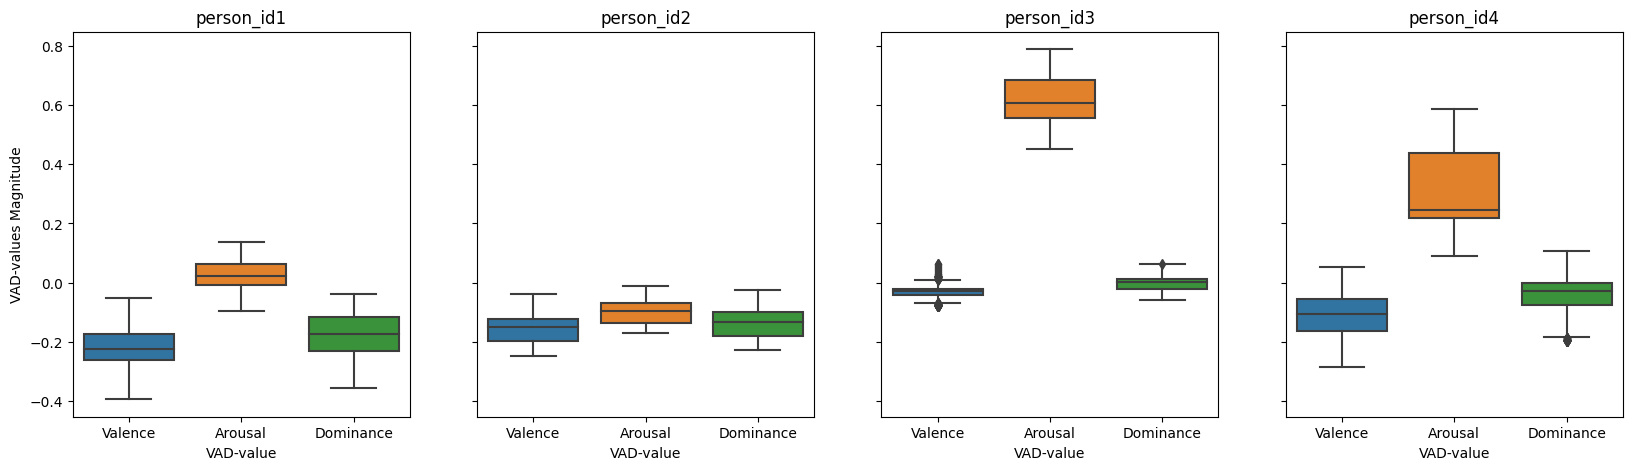

In [57]:
# Set the figure size
fig, axes = plt.subplots(1, len(pre_df['ClassID'].unique()), figsize=(20, 5), sharey=True)

# Loop over each ClassID and plot a boxplot for each emotion
for i, cid in enumerate(pre_df['ClassID'].unique()):
    # Subset the data for the current ClassID
    subset = pre_df[pre_df['ClassID'] == cid][vad]
    # Plot the boxplot for each emotion on a separate subplot
    sns.boxplot(data=subset, ax=axes[i])
    axes[i].set_title(f'{cid}')
    axes[i].set_xlabel('VAD-value')

# Set the y-axis label on the first subplot only
axes[0].set_ylabel('VAD-values Magnitude')

# Show the plot
plt.show()

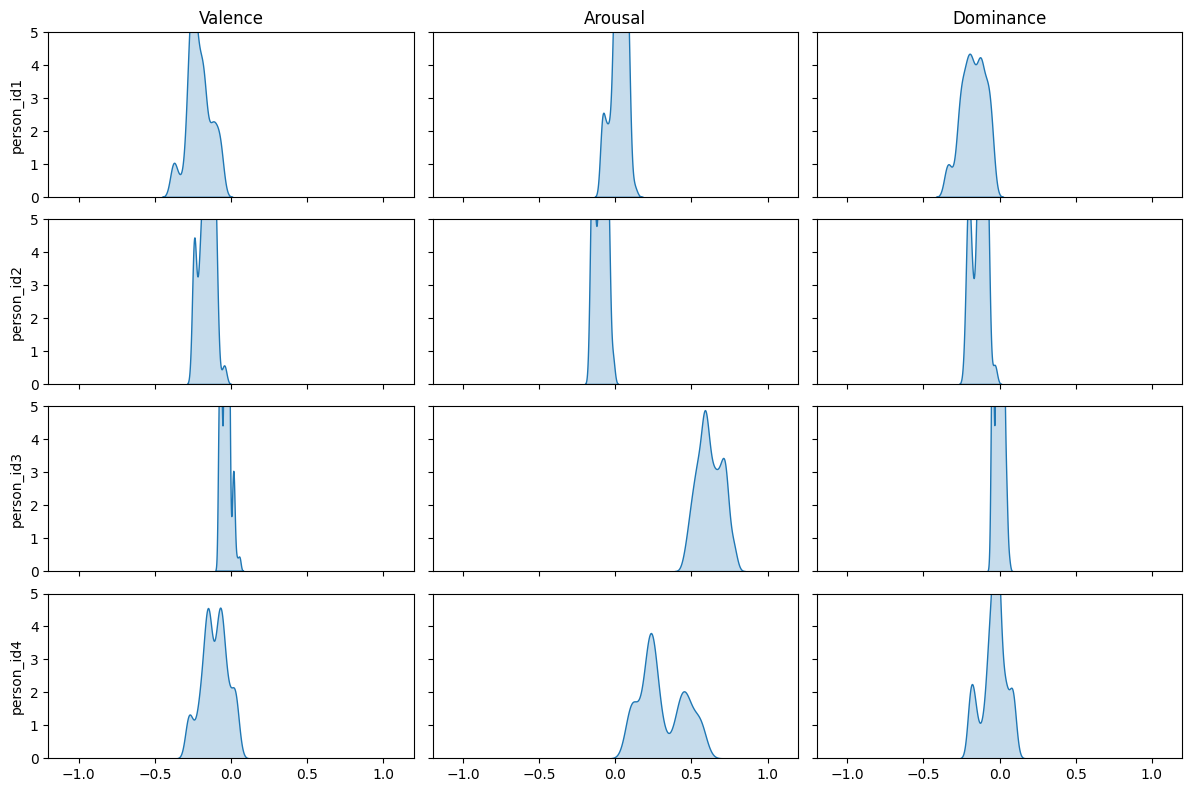

In [63]:
# Group the data by ClassID and emotion columns
grouped = pre_df.groupby(['ClassID', *vad]).size().reset_index(name='count')

# Define the size of the figure and the number of rows and columns
fig, axes = plt.subplots(nrows=len(grouped['ClassID'].unique()), ncols=len(vad), figsize=(12, 8), sharex=True, sharey=True)

# Set the x and y axis limits
xlim = (-1.2, 1.2)
ylim = (0, 5)

# Loop over each ClassID and emotion, and plot a distribution plot
for i, cid in enumerate(grouped['ClassID'].unique()):
    for j, e in enumerate(vad):
        sns.kdeplot(data=grouped[(grouped['ClassID'] == cid)], x=e, ax=axes[i, j], fill=True)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel(f'{cid}')
        if i == 0:
            axes[i, j].set_title(f'{e}')
        axes[i, j].set_xlim(xlim)
        axes[i, j].set_ylim(ylim)

# Adjust the spacing between subplots
fig.tight_layout(pad=1)
plt.show()